<a href="https://colab.research.google.com/github/suhyeon03/DeepLearning/blob/main/conv2d_%ED%95%A8%EC%88%98%EC%99%80_pooling_%ED%95%A8%EC%88%98_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# step 57
conv2d 함수와 pooling 함수

* 55 ~ 56단계에서 합성곱층과 풀링층에 대해 알아보았다.
* 이렇게 코딩하기는 귀찮을 뿐 아니라 넘파이에서 for문을 사용하면 속도가 느려진다는 단점도 있다.
* for 문은 사용하지 않고 im2col이라는 편의 함수를 사용하여 간단히 구현하고자한다.
* 참고로 im2col은 'image to column'의 약자로, 이미지에서 열로 변환한다는 의미이다.
* DeZero에서는 신경망 변환 처리를 '함수'로 구현한다.
* 그리고 매개변수를 갖는 계층은 Layer 클래스를 상속받아 매개변수 관리를 맡겼다.
* 이번 단계에서는 합성곱층에서의 처리를 comv2d함수로 구현하며, Layer 클래스를 상속한 Conv2d 계층도 구현한다.
* 그리고 풀링층에는 매개변수가 없기 때문에 (클래스는 빼고) pooling 함수만 구현한다.

im2col에 의한 전개

* im2col은 입력 데이터를 한 줄로 '전개'하는 함수로, 합성곱 연산 중 커널 계산에 편리하도록 입력 데이터를 펼쳐준다.
* 그림 57-1과 같이 3차원 텐서인 입력 데이터로부터 커널을 적용할 영역을 추출하는 것이다. (정확하게는 배치 수를 포함한 4차원 텐서로부터 커널을 적용할 영역을 꺼낸다.)

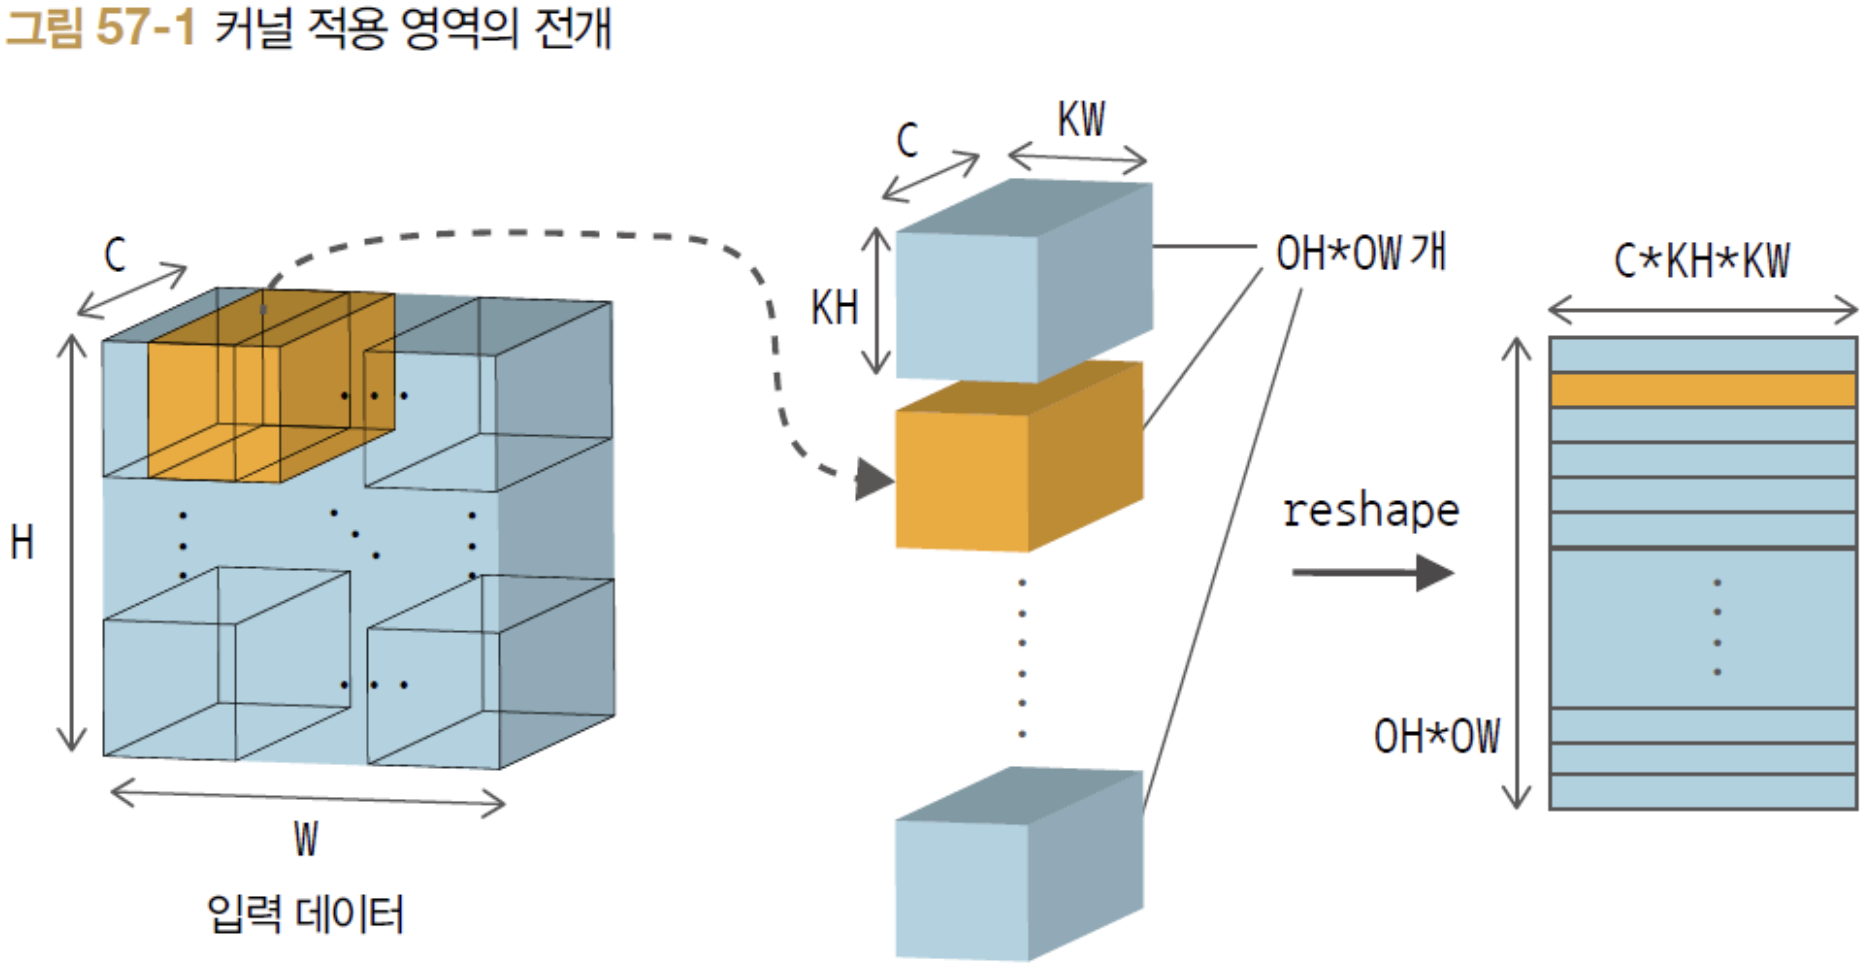

* 위 그림과 같이 커널을 적용할 영역을 꺼낸 다음, 한 줄로 형상을 바꿔 최종적으로는 '행렬(2차원 텐서)'로 변환한다. 이것이 im2col 함수가 수행하는 작업이다.
* 체이너의 im2col은 그림 57-1의 1단계까지의 작업만 수행한다.
* 왜냐하면 영역을 꺼낸 후 텐서곱을 하여 원하는 계산을 수행할 수 있기 때문이다.
* 이책에서는(텐서 곱이 아닌) 행렬 곱을 사용하기 때문에 reshape까지 해줘야한다.
* 한편 DeZero의 im2col 함수는 인수로 to_matrix 플래그를 받는데, 이값이 True일 때만 그림 57-1의 reshape 부분까지 처리해준다.

* im2col로 입력 데이터를 전개한 후에는 합성곱층의 커널(필터)을 한 줄로 전개한다.
* 그런 다음 그림 57-2처럼 두 행렬을 곱한다.
* 그림 57-2와 같이 행렬 곱을 계산하면 행렬(2차원 텐서)이 출력된다.
* 마지막으로 이 출력을 3차원 텐서(정확하게는 배치 수를 포함한 4차원 텐서로) 변환한다.
* 이상이 합성곱층의 구현 흐름이다.

* 합성곱 연산 시 im2col로 전개하면 대부분의 경우 원소 수가 원래보다 많아지기 때문에 메모리를 많이 소비한다.
* 하지만 행렬 곱으로 계산할 수 있기 떄문에 행렬 라이브러리가 제공하는 최적화된 함수의 해택을 누릴 수 있다.

* 텐서 곱은 단순히 행렬 곱의 확장으로, 축을 지정하여 두 텐서를 곱셈한후 누적하는 계산이다.

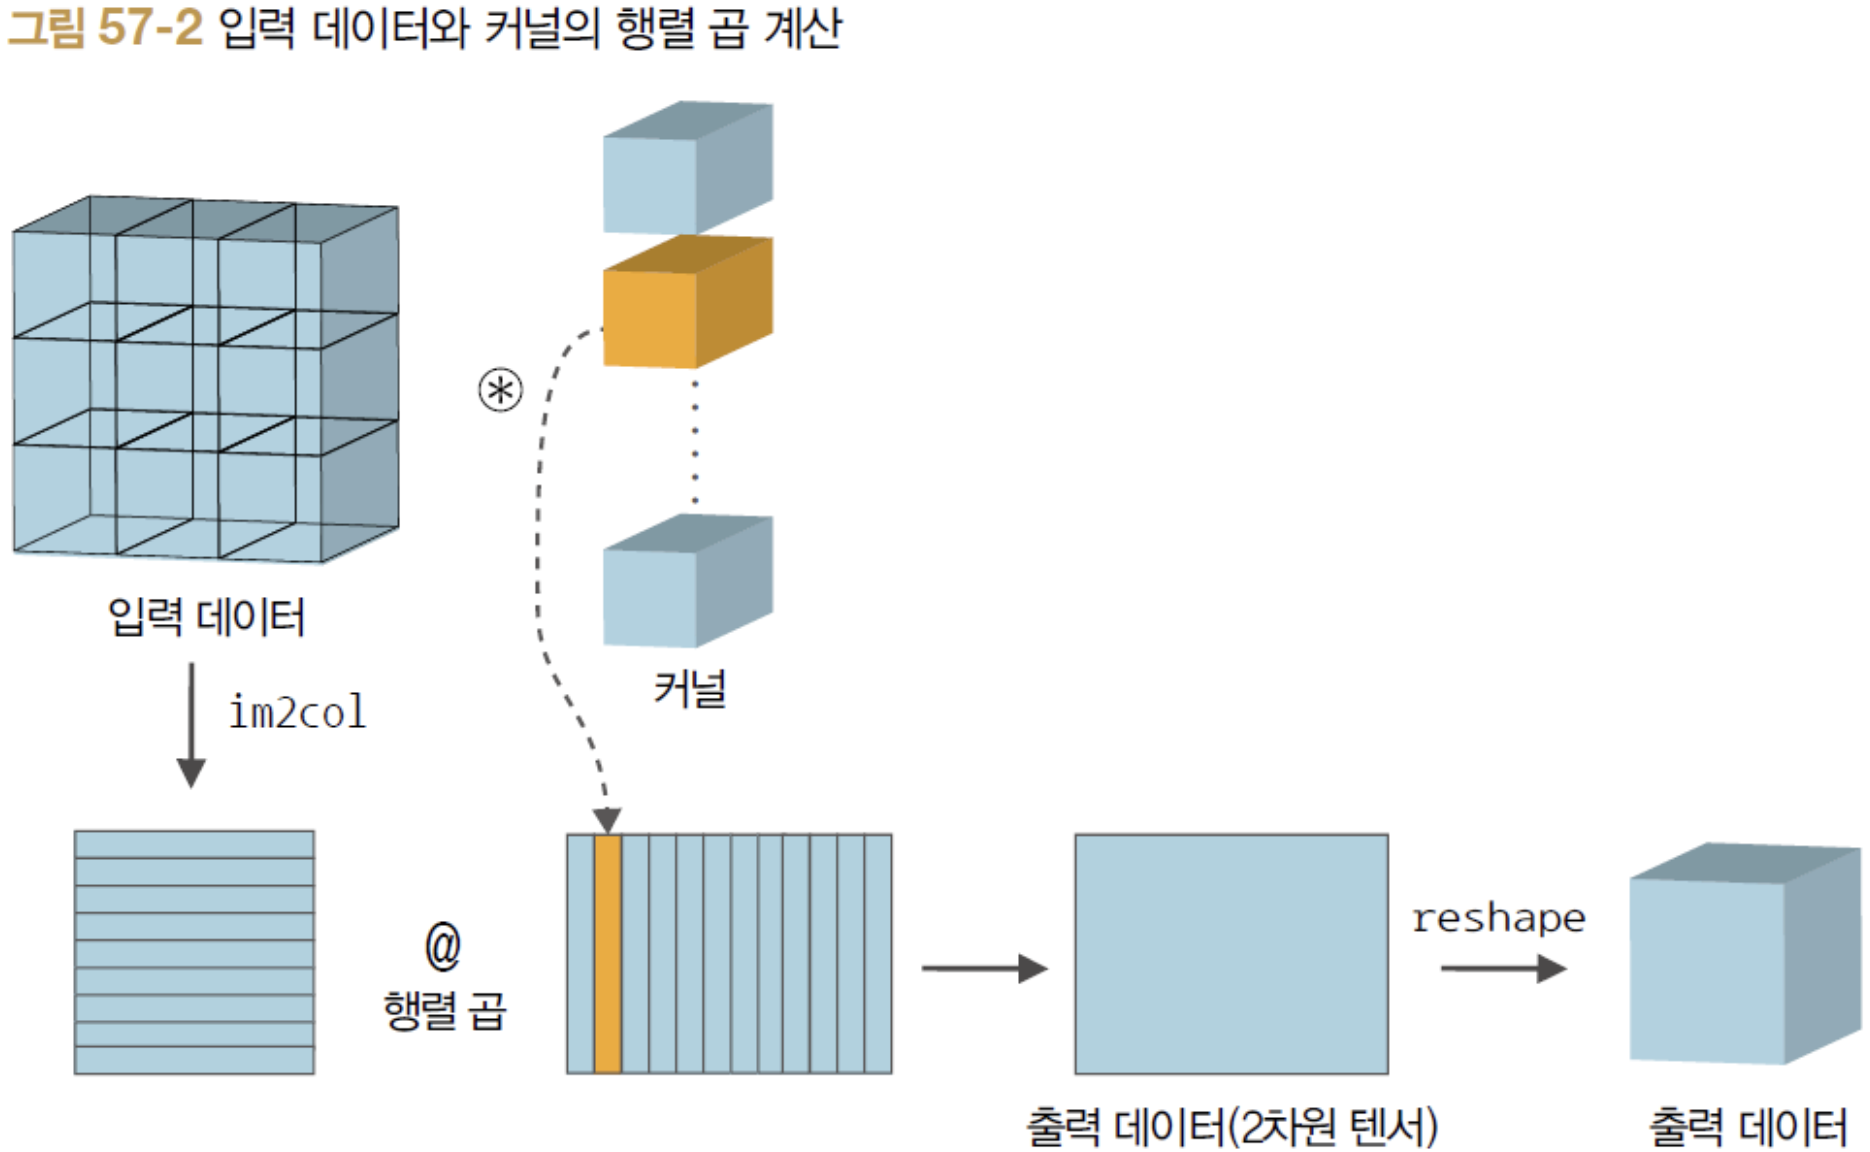

conv2d 함수 구현

* 이 책에서는 DeZero의 im2col 함수를 블랙박스처럼 사용한다고 가정합니다. (즉, 상세 구현은 신경 쓰지 않습니다.)
* 어쨌든 im2col도 DeZero 함수이므로 입력으로 Variable 인스턴스를 받으며 backward를 호출하여 미분도 계산할 수 있다.
* 그럼 DeZero의 im2col 함수에 대해 살펴보자

In [ ]:
im2col(x, kernel_size, stride=1, pad=0, to_matrix=True)

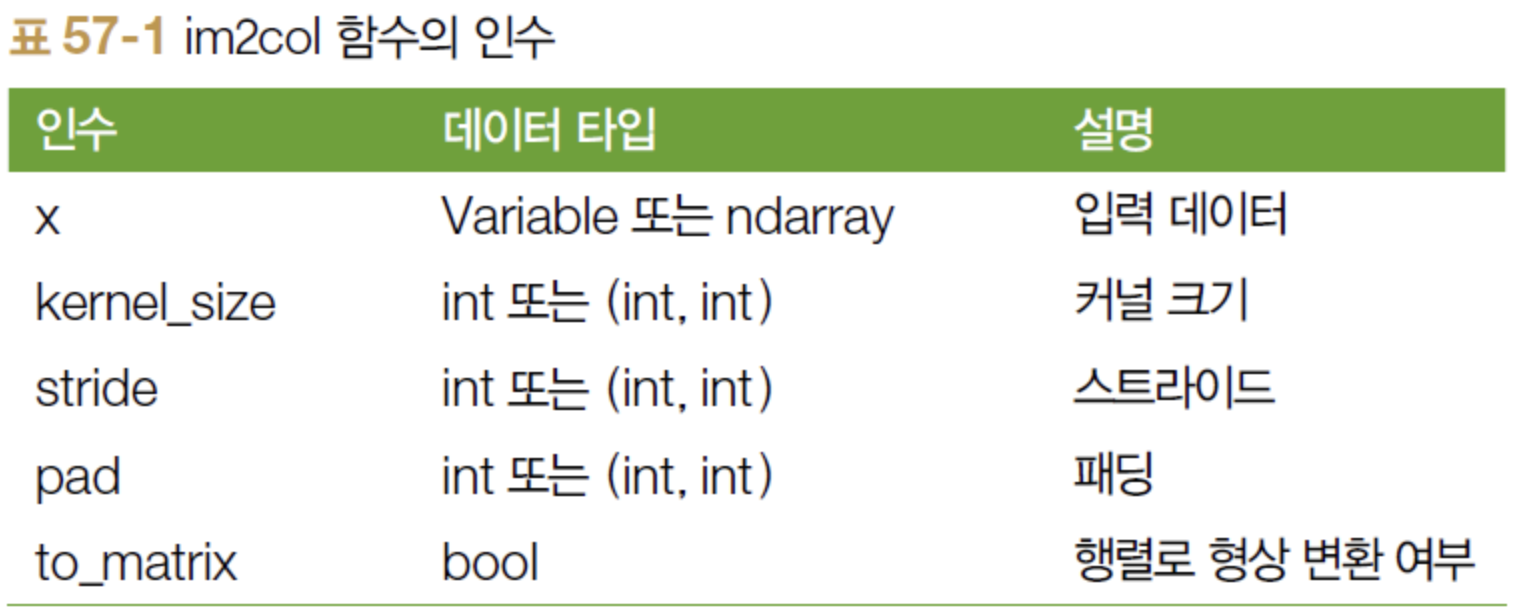

* 인수 kernel_size는 int 또는 (int, int) 튜플로 제공한다.
* 만약 튜플로 주어지면 첫 번째 원소가 높이에, 두 번째 원소가 너비에 대응한다.
* int로 주어지면 높이와 너비가 같다고 해석한다.
* 인수 stride와 pad도 같은 방식으로 해석한다.
* 마지막 인수는 to_matrix 플래그이다.
* 이 플래그가 True면 커널을 적용할 영역을 추출한 후 '행렬'로 형상 변환한다.

In [1]:
!git clone https://github.com/GoGiants1/dl-from-scratch-3.git
import sys
sys.path.append('dl-from-scratch-3')

Cloning into 'dl-from-scratch-3'...
remote: Enumerating objects: 2327, done.
remote: Counting objects: 100% (2327/2327), done.
remote: Compressing objects: 100% (852/852), done.
remote: Total 2327 (delta 1503), reused 2287 (delta 1463), pack-reused 0 (from 0)
Receiving objects: 100% (2327/2327), 33.93 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (1503/1503), done.


In [2]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x1 = np.random.rand(1, 3, 7, 7) # 배치 크기 = 1
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)  # (9, 75)

x2 = np.random.rand(10, 3, 7, 7)  # 배치 크기 = 10
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)  # (90, 75)

(9, 75)
(90, 75)


/content/dl-from-scratch-3/dezero/datasets.py:305: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  return fine_labels if label_type is "fine" else coarse_labels


* 각각에 im2col 함수를 적용하면 두 경우 모두에서 두 번째 차원의 원소 수는 75이다.
* 커널의 원소 수와 일치하는 결과다. (채널 수 3에 (5,5) 형상의 데이터).
* 그리고 첫 번째 예의 결과는 (9, 75)인 반면, 두 번째 예는 배치 크기가 10이므로 그 10배인 (90, 75)가 되었다.
* 다음은 im2col 함수를 사용하여 합성곱 연산을 수행하는 함수를 구현할 차례이다.
* 그전에 pair(x)라는 편의 함수부터 구현한다.

In [3]:
def pair(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, tuple):
        assert len(x) == 2
        return x
    else:
        raise ValueError

* pair(x) 함수는 인수 x가 int라면 (x,x) 형태의 튜플로 변환해 반환하고, x가 원소2개짜리 튜플이면 그대로 돌려준다.
* 이 함수를 사용하면 다음과 같이 인수 타입이 int든 (int, int)든 상관없이 원소 2개짜리 튜플을 얻을 수 있다.

In [4]:
from dezero.utils import pair

print(pair(3))
print(pair((1, 2)))

(3, 3)
(1, 2)


In [5]:
def conv2d_simple(x, W, b=None, stride=1, pad=0):
    x, W = as_variable(x), as_variable(W)

    Weight = W
    N, C, H, W = x.shape
    OC, C, KH, KW = Weight.shape
    SH, SW = pair(stride)
    PH, PW = pair(pad)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)

    col = im2col(x, (KH, KW), stride, pad, to_matrix=True) # 1
    Weight = Weight.reshape(OC, -1).transpose() # 2
    t = linear(col, Weight, b) # 3
    y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2) # 4
    return y

* 우선 1에서 입력 데이터를 im2col로 전개한다.
* 2에서는 커널 Weight를 그림 57-2에서와 같이 한줄로 펼쳐 재정렬한다.
* 여기에서 Weight.reshape(OC, -1)처럼 마지막 인수로 -1을 주었는데, 이는 reshape 함수의 편의 기능이다.
* 마지막 인수를 -1로 지정하면 그 앞의 인수들로 정의한 다차원 배열에 전체 원소들을 적절히 분배해준다.
* 예를 들어 (10, 3, 5, 5) 형상의 배열이라면 원소가 총 750개인데, 이 배열에 reshape(10, -1)을 수행하면 (10, 75) 형상의 배열로 바뀐다. (총 750개를 10개의 묶음으로 배분한 결과이다.)

* 그리고 3에서 행렬 곱을 계산한다. 이때 선형 변환인 linear 함수를 사용하여 편향까지 포함한 계산을 수행한다.
* 마지막으로 4에서 출력 크기를 적절한 형상으로 바꾼 후 DeZero의 transpose 함수를 사용했다. 38단계에서 설명한대로 transpose 함수는 텐서의 축 순서를 바꿔주는데, 여기에서는 그림 57-3처럼 교체한 것이다.

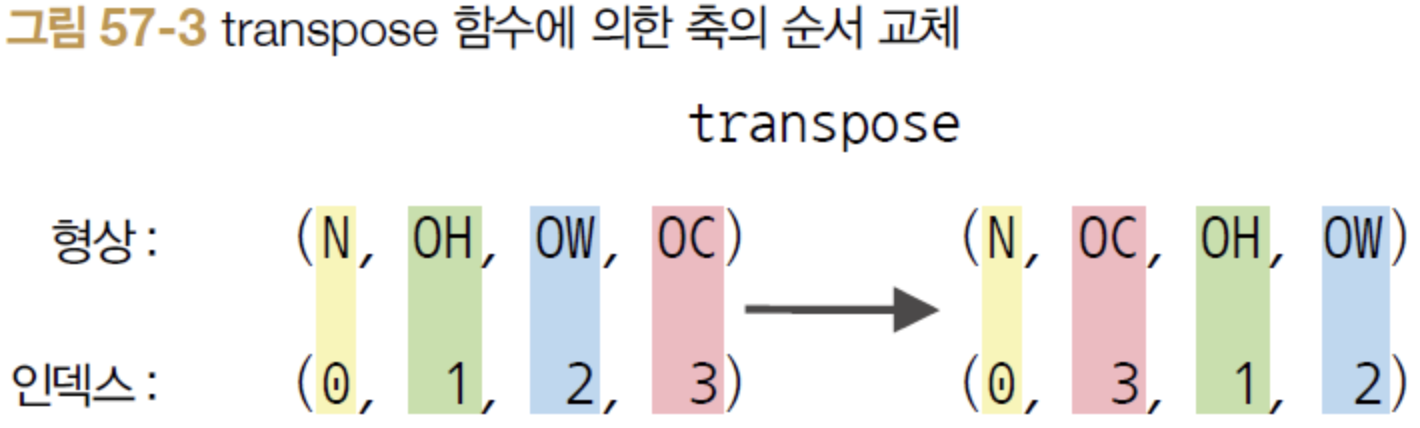

In [7]:
N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3,3)

x = Variable(np.random.randn(N, C, H, W))
W = np.random.rand(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()

print(y.shape)
print(x.grad.shape)

(1, 8, 15, 15)
(1, 5, 15, 15)


* Conv2 클래스에서는 순전파 시 im2col 메서드를 이용하는데, (행렬 곱이 아닌) 텐서 곱방식으로 계산한다.
* 또한 im2col로 전개한 2차원 텐서(변수 이름은 col이다.)는 사용 후 메모리에서 즉시 삭제한다.
* 그리고 역전파는 '전치 합성곱'방식으로 계산한다.

Conv2d 계층 구현
* 함수가 아닌 계층으로서 Conv2d 클래스를 구현한다.

In [ ]:
class Conv2d(Layer):
    def __init__(self, out_channels, kernel_size, stride=1,
                 pad=0, nobias=False, dtype=np.float32, in_channels=None):

        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if in_channels is not None:
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_channels, dtype=dtype), name='b')

    def _init_W(self, xp=np):
        C, OC = self.in_channels, self.out_channels
        KH, KW = pair(self.kernel_size)
        scale = np.sqrt(1 / (C * KH * KW))
        W_data = xp.random.randn(OC, C, KH, KW).astype(self.dtype) * scale
        self.W.data = W_data

    def forward(self, x):
        if self.W.data is None:
            self.in_channels = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)

        y = F.conv2d(x, self.W, self.b, self.stride, self.pad)
        return y

* Layer 클래스를 상속하고, 초기화 시 표 57-2의 인수들을 받는다.

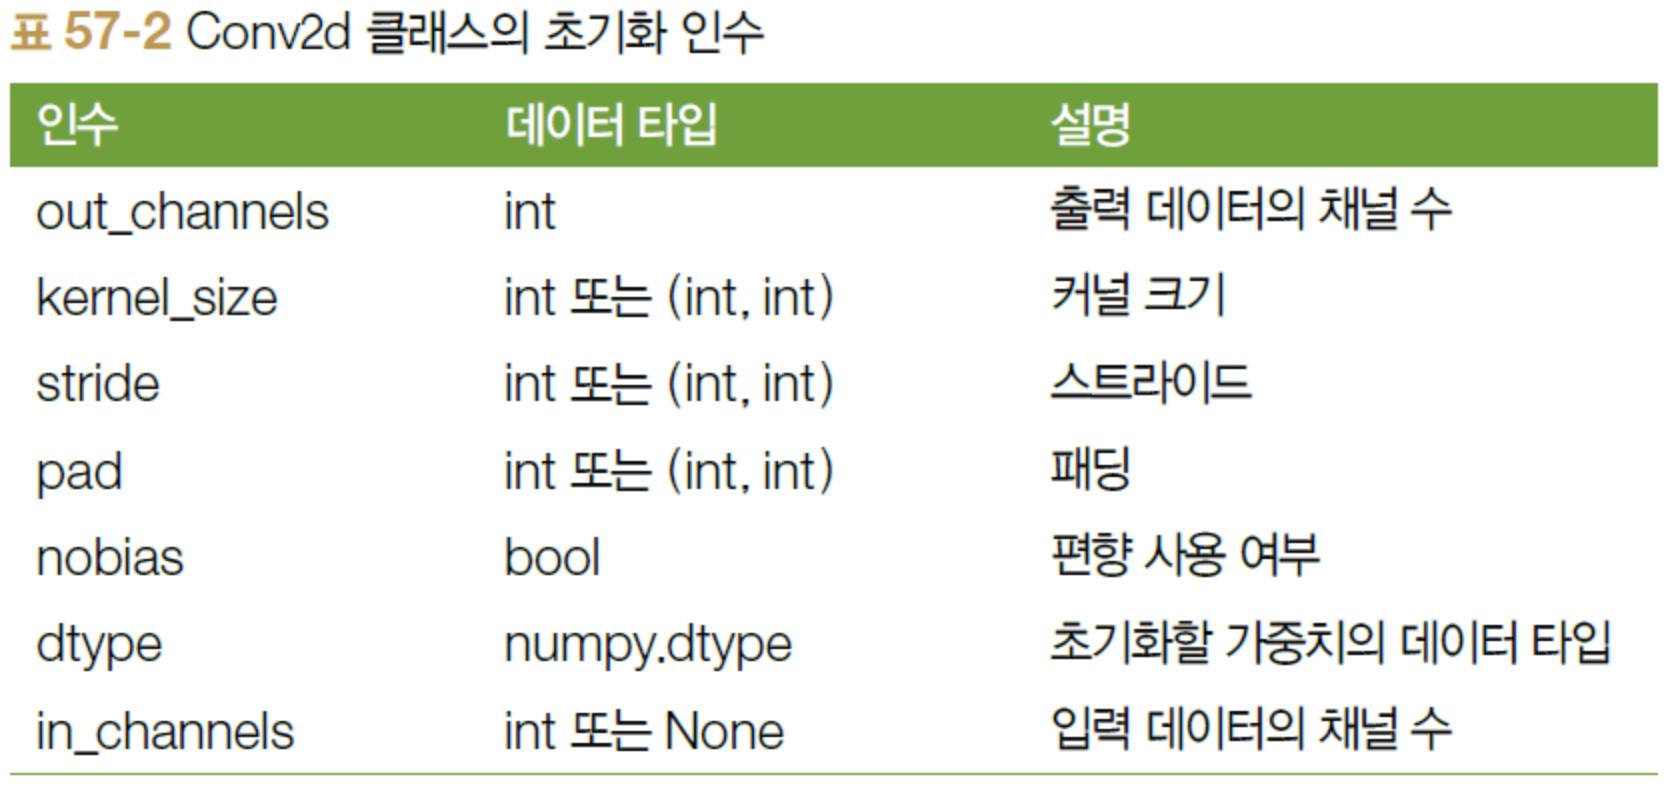

* 표 57-2에서 주의할 점은 in_channels의 기본값이 None 이라는 것이다.
* 이 값이 None이면 forward(x)에 주어지는 x의 형상으로부터 in_channels의 값을 얻고, 그 시점(순전파)에 가중치 데이터를 초기화한다.
* 완전연결계층의 Linear 계층과 동일한 작동 방식이다.
* 주요 처리는 앞서 구현한 conv2d_simple(혹은 conv2d)을 이용한다.

pooling 함수 구현

* 마지막으로 poolig 함수를 구현한다.
* 이 함수도 conv2d_simple과 마찬가지로 im2col을 사용하여 입력 데이터를 전개한다.
* 그러나 풀링은 채널 방향과는 독립적이라는 점이 합성곱층과 다르다.
* 다시말해 아래 그림과 같이 풀링의 적용 영역은 채널마다 독립적으로 전개한다.

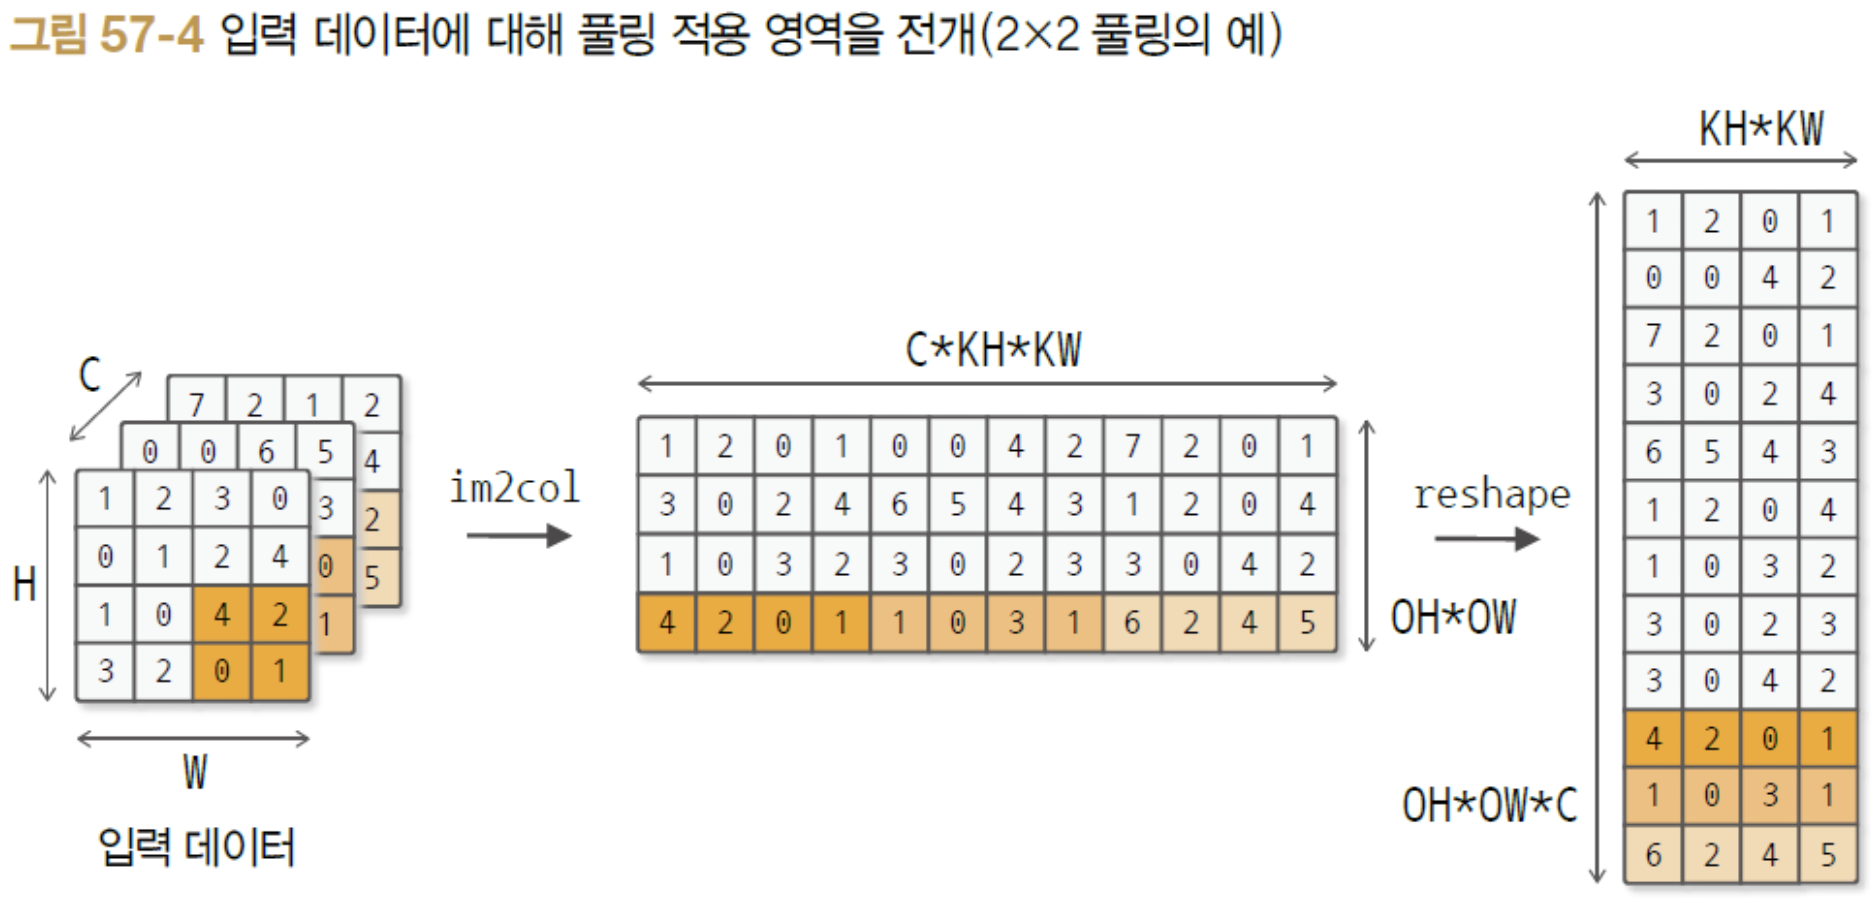

* 이렇게 전개한 후 전개된 행렬의 각 행렬로 최댓값을 구해 적절한 형상으로 바꾸면 끝이다.

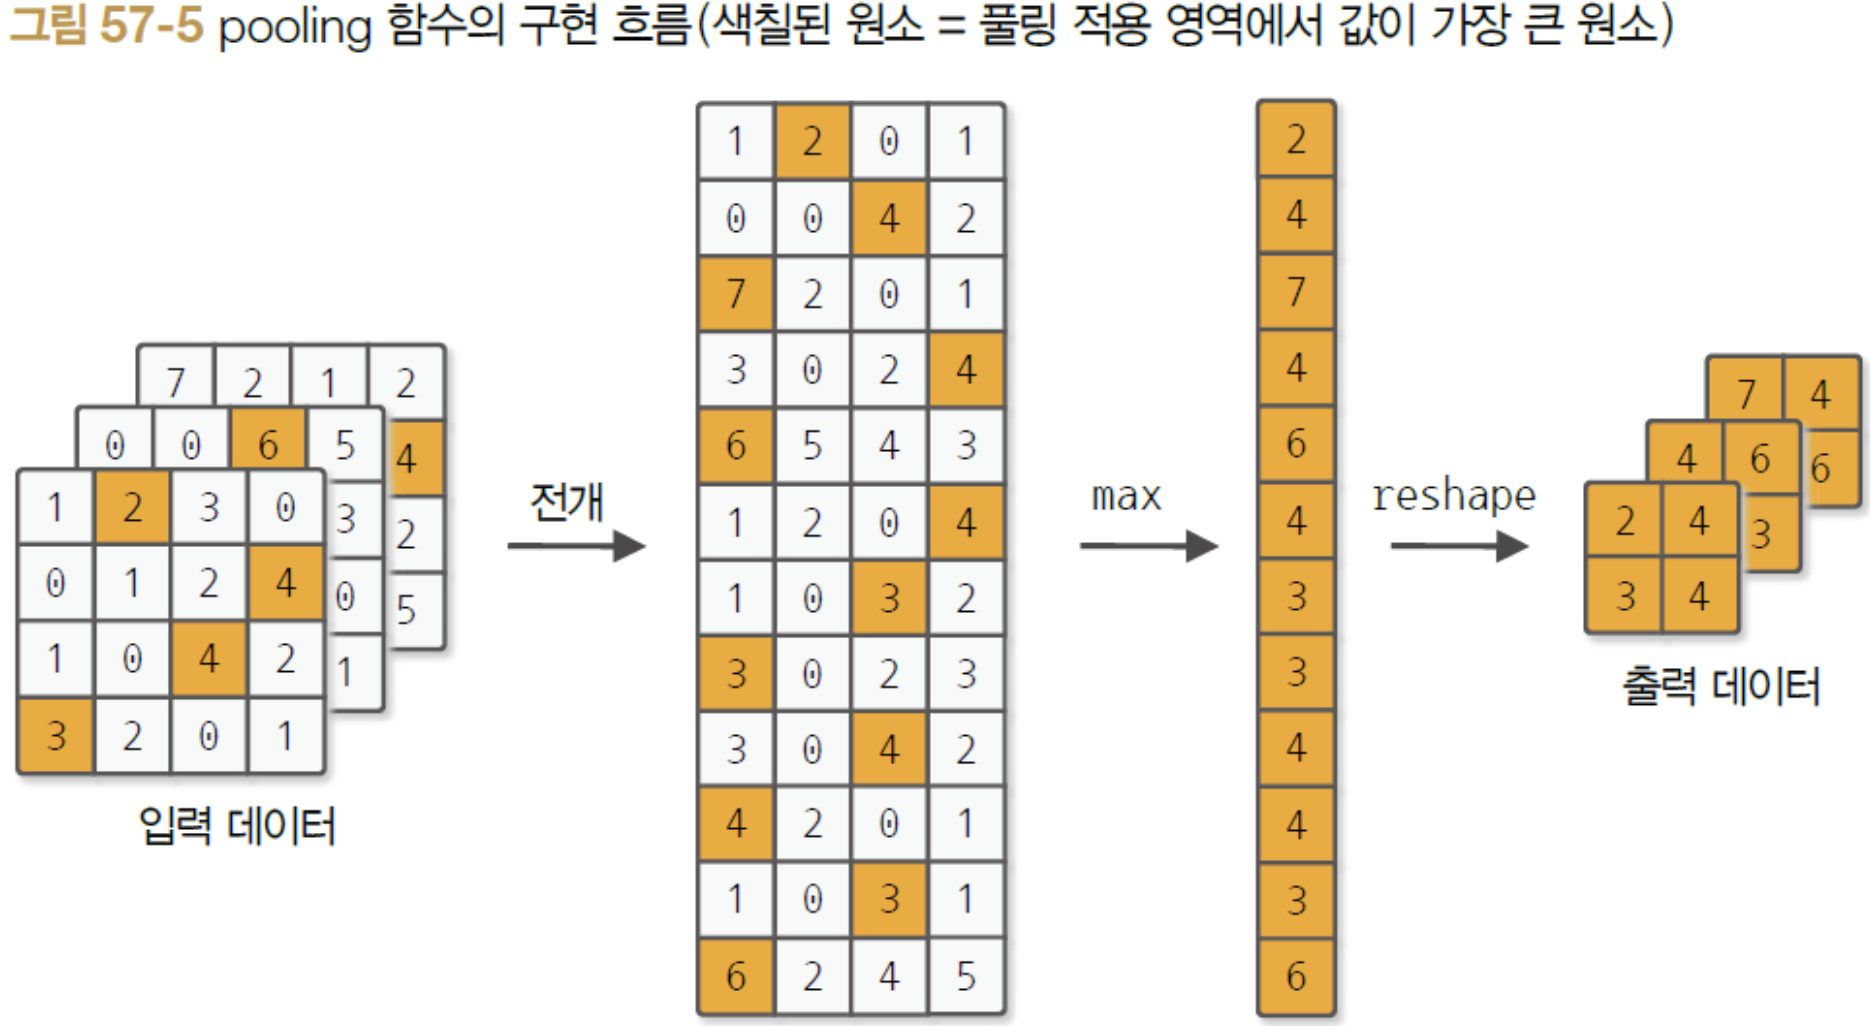

In [8]:
def pooling_simple(x, kernel_size, stride=1, pad=0):
    x = as_variable(x)

    N, C, H, W = x.shape
    KH, KW = pair(kernel_size)
    PH, PW = pair(pad)
    SH, SW = pair(stride)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)

    col = im2col(x, kernel_size, stride, pad, to_matrix=True) # 1 전개
    col = col.reshape(-1, KH * KW)
    y = col.max(axis=1) # 2 최댓값
    y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2) # 3 형상 변환
    return y

* 1에서의 입력 데이터를 전개하고, 2에서 각 행의 최댓값을 찾고, 3에서 적절한 크기로 출력의 형상을 변환한다.